### Machine learning Explainability approaches 

This notebook uses Kaggle's House Prices: Advanced regression (https://www.kaggle.com/c/house-prices-advanced-regression-techniques) techniques to apply different explainability methods. 

The following will be explored: 

- Feature importances calculated with feature permutation
- Global Surrogate models
 
.... later:  
    - Anchors
    - Data Shapley 
    
Refer to other notebooks for other methods. 

### Feature Importances 

Feature importances can be calculated not only for a tree-based model but for any other type of model. The feature importance is roughly the increase in the model error as the values of the feature are permuted. 

Here, I will compare the default feature importance output after a random forest and one calculated with the *eli5* package.

**Advantages**:
- Nice interpretation and global insight into the model's behavior
- Comparable across different problems and units of the target

**Disadvantages**:
- Like other permutation-dependent methods, results might differ when we repeat the process
- Need access to the true label
- If correlated features, the importance is split such that one feature might appear not important

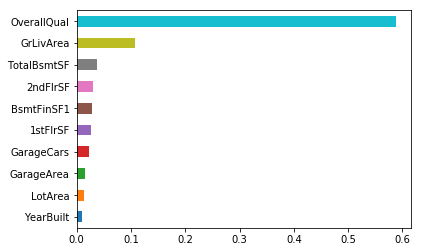

In [180]:
# Traditional random forest feature importances 

feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=True)[-10:].plot(kind='barh') 

Feature importances calculated with a package

In [181]:
import eli5
#from eli5.sklearn import PermutationImportance

# Explain weights and put them to a dataset; Note: the feature_names argument requires a list of the feature names 
feat_import_df = eli5.explain_weights_df(rf, feature_names=list(X.columns))
feat_import_df= feat_import_df.set_index('feature')
feat_import_df.head(15)

,weight,std
feature,,
OverallQual,0.587194,0.060859
GrLivArea,0.107828,0.035305
TotalBsmtSF,0.038313,0.021463
2ndFlrSF,0.029917,0.031253
BsmtFinSF1,0.028629,0.016649
1stFlrSF,0.026908,0.029579
GarageCars,0.022677,0.035087
GarageArea,0.014700,0.014089
LotArea,0.013771,0.012345


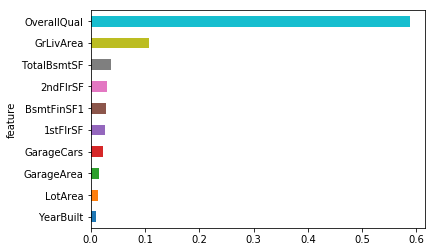

In [182]:
# Plot the top 10 most important features: In this case, they are the same as the ones calculated with the defauly feature import
feat_import_df['weight'].head(10).sort_values(ascending=True).plot(kind='barh')

### Global surrogate models 

Global surrogate models train an interpretable model (such as a liner/logistic regression or a decision tree) after the black box model. 

We keep track of how well the model replicates the predictions of the black box model, for example, by keeping track of some metric (such as R-squared for regression).

**Advantages**:
- Flexible and intuitive (easy to implement and explain)
- No special packages needed

**Disadvanatges**:
- It never sees the real outcome of the model, so it makes approximations about approximations
- Not clear what threshold of the model metric is good enough 

In [187]:
# Build predictions of the RF model and fit a shallow DT model on the features X and the predictions

from sklearn.tree import DecisionTreeRegressor,export_graphviz

predictions = rf.predict(X)
dt = DecisionTreeRegressor(random_state = 100, max_depth=2)
dt.fit(X, predictions)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=100, splitter='best')

In [184]:
#Visualize the decision tree

# NOTE: Graphviz has some problems finding the executable

from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,   
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

InvocationException: GraphViz's executables not found

It seems sklearn.tree has a plot_tree() built-in function, which can just employ instead.

[Text(170.9,187.033,'OverallQual <= 7.5\nentropy = 5619239872.215\nsamples = 1460\nvalue = 180660.074'),
 Text(85.45,112.22,'OverallQual <= 6.5\nentropy = 2112247558.967\nsamples = 1231\nvalue = 157746.308'),
 Text(42.725,37.4067,'entropy = 1137836805.517\nsamples = 912\nvalue = 140309.901'),
 Text(128.175,37.4067,'entropy = 1543850243.809\nsamples = 319\nvalue = 207595.848'),
 Text(256.35,112.22,'OverallQual <= 8.5\nentropy = 6477024182.579\nsamples = 229\nvalue = 303834.071'),
 Text(213.625,37.4067,'entropy = 2827989544.837\nsamples = 168\nvalue = 274563.417'),
 Text(299.075,37.4067,'entropy = 7668533332.936\nsamples = 61\nvalue = 384448.331')]

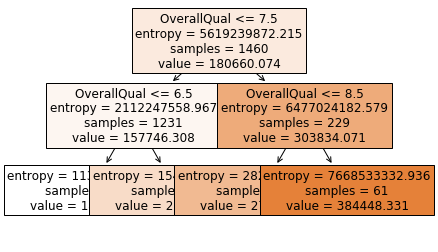

In [188]:
from sklearn.tree import plot_tree

plot_tree(dt, feature_names=list(X.columns), precision=3, 
          filled=True, fontsize=12, impurity=True)

In [189]:
# Inspect the R-squared (the default scoring matrix for score() after a regressor): 
# It is relatively high, so the surrogate model is a good approximation of the black box model
dt.score(X, predictions)

0.6985554635663893